In [1]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid import H2OGridSearch

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
  Starting server from c:\users\craig\appdata\local\programs\python\python35\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Craig\AppData\Local\Temp\tmp9b8lwf53
  JVM stdout: C:\Users\Craig\AppData\Local\Temp\tmp9b8lwf53\h2o_Craig_started_from_python.out
  JVM stderr: C:\Users\Craig\AppData\Local\Temp\tmp9b8lwf53\h2o_Craig_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_Craig_pmjkvr
H2O cluster total nodes:,1
H2O cluster free memory:,10.66 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [3]:
df = h2o.import_file('Mobile Price Classification.csv',col_types = {'price_range':"enum"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
train, test = df.split_frame(seed = 3, destination_frames=["train.hex", "test.hex"])

In [5]:
response = "price_range"
predictors = df.col_names[:-1]

In [6]:
RandF_v1 = H2ORandomForestEstimator(model_id = "RandF_v1.hex",
                                  score_tree_interval = 10, ntrees = 500,
                                  ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                  ## for 5 consecutive scoring events
                                  stopping_rounds = 5, stopping_metric = "auto", stopping_tolerance = 0.001
                                  )

In [7]:
RandF_v1.train(x = predictors, y = response, 
             training_frame = train, validation_frame = test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [8]:
RandF_v1.confusion_matrix(data=test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,Error,Rate
113.0,9.0,0.0,0.0,0.0737705,9 / 122
9.0,107.0,15.0,0.0,0.1832061,24 / 131
0.0,9.0,97.0,11.0,0.1709402,20 / 117
0.0,0.0,13.0,112.0,0.104,13 / 125
122.0,125.0,125.0,123.0,0.1333333,66 / 495


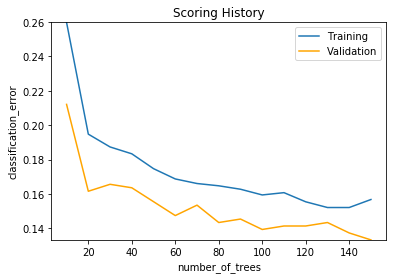

In [9]:
RandF_v1.plot()

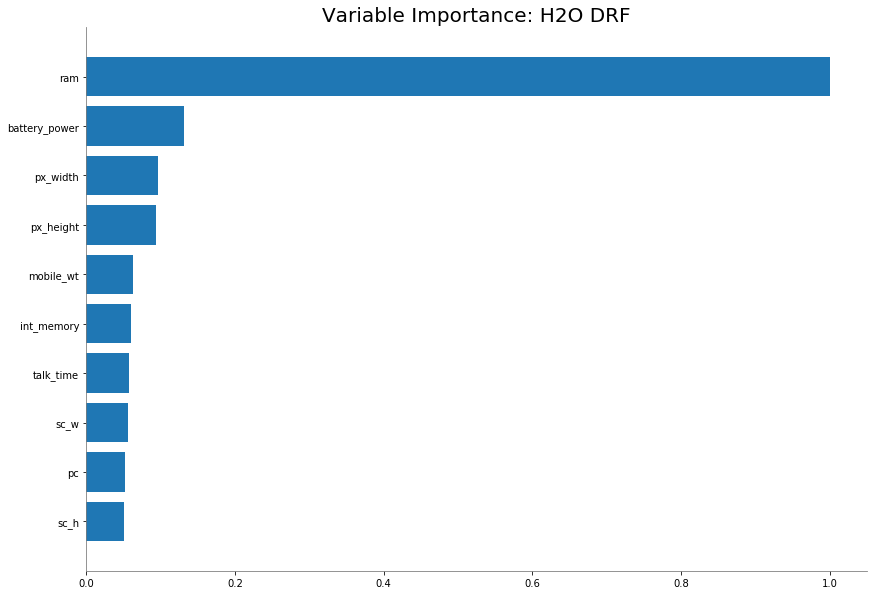

In [10]:
RandF_v1.varimp_plot()

In [11]:
search_criteria = {
    ## Random grid search
    'strategy':"RandomDiscrete",      
    
    ## limit the runtime to 60 minutes
    'max_runtime_secs':3600,         
    
    ## build no more than 15 models for example purposes
    ## 'max_models':15,                  
  
    ## random number generator seed to make sampling of parameter combinations reproducible
    'seed':3,                        
  
    # early stopping once the leaderboard of the top 5 models is converged to 0.1% relative difference
    'stopping_rounds':5, 'stopping_metric':"auto", 'stopping_tolerance':1e-3
}


hyper_params = hyper_params = {
    ## search for the best categorical encoding
    ## 'categorical_encoding':["Enum", "OneHotExplicit", "Binary", "Eigen", "LabelEncoder", 
    ##                        "SortByResponse", "EnumLimited"],
    
    ## search a large space of the number of bins for split-finding for categorical columns
    ## 'nbins_cats':[16, 32, 64, 128]
    
    ## ntrees
    ##'ntrees':50,
    
    ## max_depth
    ## 'max_depth':10
}
RandF_v2 = H2ORandomForestEstimator(model_id = "RandF_v2.hex",
                                  score_tree_interval = 10, ntrees = 500,
                                  ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                  ## for 5 consecutive scoring events
                                  stopping_rounds = 5, stopping_metric = "auto", stopping_tolerance = 0.001, 
                                  )

RandF_v2 = H2OGridSearch(grid_id="RandF_v2_Tune.hex", hyper_params=hyper_params, 
                         model=RandF_v2, search_criteria=search_criteria)

In [12]:
RandF_v2.train(x = predictors, y = response, 
             training_frame = train, validation_frame = test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [13]:
gbm_v1 = H2OGradientBoostingEstimator(model_id = "gbm_v1.hex",
                                      score_tree_interval = 10, ntrees = 500,
                                      ## early stopping once the validation AUC doesn't improve by at least 0.1% 
                                      ## for 5 consecutive scoring events
                                      stopping_rounds = 5, stopping_metric = "auto", stopping_tolerance = 0.001
                                     )
gbm_v1.train(x = predictors, y = response, 
             training_frame = train, validation_frame = test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [14]:
gbm_v1.confusion_matrix(data=test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,Error,Rate
116.0,6.0,0.0,0.0,0.0491803,6 / 122
10.0,112.0,9.0,0.0,0.1450382,19 / 131
0.0,5.0,107.0,5.0,0.0854701,10 / 117
0.0,0.0,12.0,113.0,0.096,12 / 125
126.0,123.0,128.0,118.0,0.0949495,47 / 495


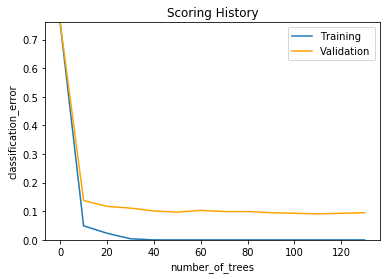

In [15]:
gbm_v1.plot()

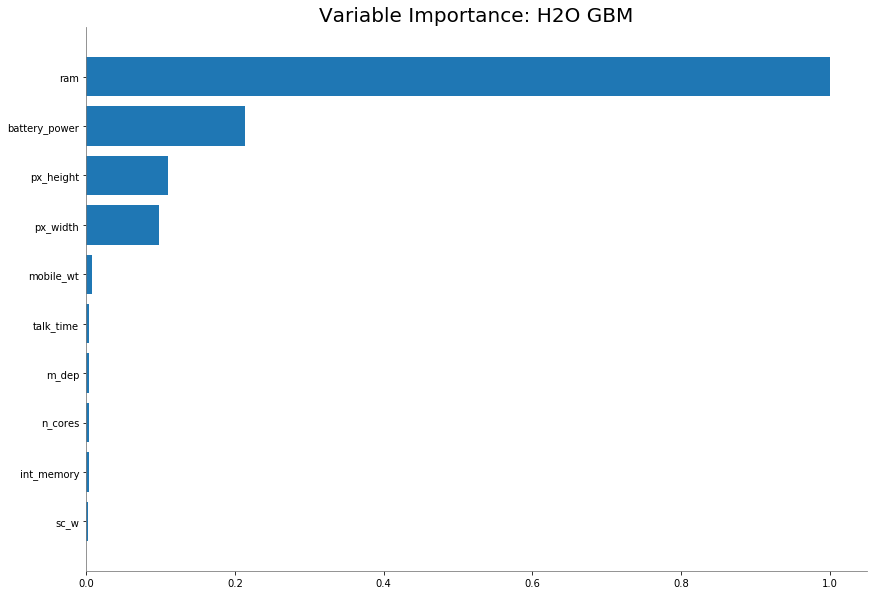

In [16]:
gbm_v1.varimp_plot()